<a href="https://colab.research.google.com/github/colivarese/CarSCAN/blob/main/CarSCAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CarSCAN assigment for Computer Vision Internship
## Task 2.2 Damage Detection

### On this assigment we have to train a bbox detector, instance segmentation or a semantic segmention model.<br>
### We will use the Ruby Card Damage Dataset from Kaggle

# Install Kaggle Dependecy
### Install the kaggle dependencies to retrieve the dataset from the site without downloading it

In [ ]:
pip install kaggle

# Set Kaggle API Token 
### Use our personal Kaggle Token to use the kaggle api functions.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


# Download the dataset

In [ ]:
!kaggle datasets download "ruby09/damage-detection-dataset"

 62% 9.00M/14.4M [00:00<00:00, 69.7MB/s]
100% 14.4M/14.4M [00:00<00:00, 70.7MB/s]


In [ ]:
!unzip damage-detection-dataset.zip

Archive:  damage-detection-dataset.zip
  inflating: img/1.jpg               
  inflating: img/10.jpg              
  inflating: img/13.jpg              
  inflating: img/14.jpg              
  inflating: img/15.jpg              
  inflating: img/16.jpg              
  inflating: img/17.jpg              
  inflating: img/18.jpg              
  inflating: img/19.jpg              
  inflating: img/2.jpg               
  inflating: img/20.jpg              
  inflating: img/21.jpg              
  inflating: img/22.jpg              
  inflating: img/23.jpg              
  inflating: img/24.jpg              
  inflating: img/25.jpg              
  inflating: img/26.jpg              
  inflating: img/27.jpg              
  inflating: img/29.jpg              
  inflating: img/3.jpg               
  inflating: img/30.jpg              
  inflating: img/31.jpg              
  inflating: img/32.jpg              
  inflating: img/33.jpg              
  inflating: img/34.jpg              
  inflating

# Installing Detectron2
### We will use the Facebook's model Detectron2 to perform the semantic segmentation, the selected dataset contains images of cars with segmented damage.

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-itkjcy1s
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-itkjcy1s
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
     |████████████████████████████████| 145 kB 42.9 MB/s 
     |████████████████████████████████| 130 kB 49.3 MB/s 
     |████████████████████████████████| 749 kB 49.9 MB/s 
     |████████████████████████████████| 843 kB 41.4 MB/s 
     |████████████████████████████████| 596 kB 38.1 MB/s 
     |████████████████████████████████| 112 kB 51.0 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5676645 sha256=2b9ae3e2f29f4e5ec88b5f3fb0763d9561bae46bada8ad665dd0e17469b1a6d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_zyb4ha/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore

# Import Torch to the the Detectron2 model, remeber to use a CUDA device.

In [ ]:
import torch, torchvision
print(torch.cuda.is_available())
import os, pickle ,random

True


In [ ]:
#!pip install pyyaml==5.1

#import torch
#TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
#CUDA_VERSION = torch.__version__.split("+")[-1]
#print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

# Import some common Detectron2 dependencies

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# Set the random seed to reproduce the results.


In [ ]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

# Register the coco instances of the training data, it takes an input the name of the instance, the json file with the annotations and the path to the training images.

In [ ]:
register_coco_instances('Training data',
                        metadata = dict(),
                        json_file = "./train/COCO_train_annos.json",
                        image_root = "./train"
                        )

# Data Augmentation
### We will define some data agumentation to have more variety on the training set, we have to be careful, the number of images is low, using too much augmentation could be worse than not using any at all. <br>
###  

*   Random brightness (0.8-1.2) to simulate different lightning conditions.
*   Random contrast (0.9-1.1) to simulate shadows.
*   Random saturation (0.9-1.1) to have color robustness.
*   RandomFlip to simulate different angles.

In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy


def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        #T.Resize((960,960)),
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.9, 1.1),
        T.RandomSaturation(0.9, 1.1),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Overload the CustomTrainer class to use the designed Data Augmentation.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Some data visualization
## Define the Dataset and Metadata Catalogs to retrieve the images and annotations.

[01/10 17:09:20 d2.data.datasets.coco]: Loaded 59 images in COCO format from ./train/COCO_train_annos.json


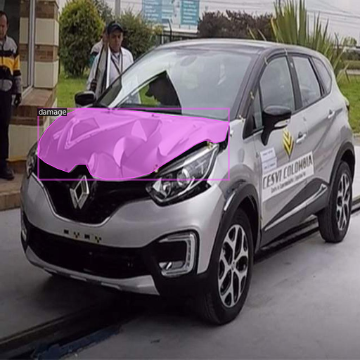

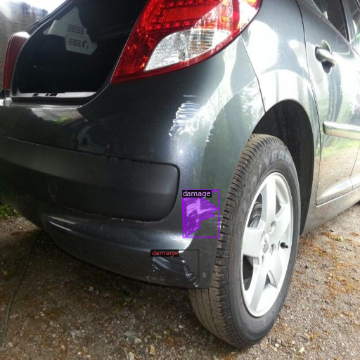

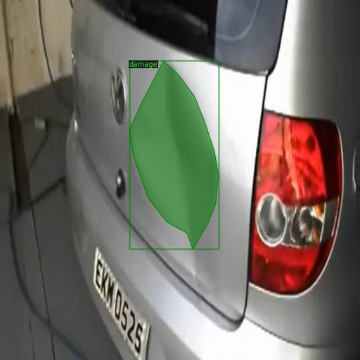

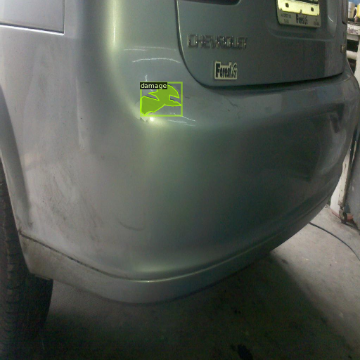

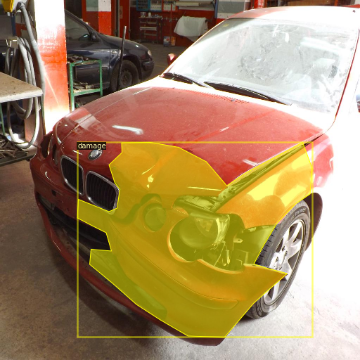

In [ ]:
number_of_samples = 4

dataset_dicts= DatasetCatalog.get('Training data')
crash_metadata = MetadataCatalog.get('Training data')

for d in random.sample(dataset_dicts, number_of_samples+1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=crash_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(cv2.resize(out.get_image()[:, :, ::-1], (360,360)))
    #cv2.resize(im, (960, 540))  

# Training a pre-trained Detectron2 Model
### We will load a pretrained Detectron2 model with a RCNN 50 base model.


*   Define the training data
*   Define the optimum number of workers
*   Load the pretrained weights on COCO dataset.
*   Number of images per batch
*   Define a CONSTANT learning rate, this was adjusted with different runs.
*   Define number of iterations.
*   Set the larning rate as constant through the whole training 
*   Set the number of ROI heads 
*   Set the number of classes, is just 1, the damage.


In [ ]:
from detectron2.engine import DefaultTrainer

#from detectron2.config import get_cfg


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Training data",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0007  # pick a good LR
cfg.SOLVER.MAX_ITER = 900   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.SEED = seed

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/10 17:09:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:04, 38.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[01/10 17:09:43 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/10 17:10:17 d2.utils.events]:  eta: 0:24:24  iter: 19  total_loss: 1.923  loss_cls: 0.7168  loss_box_reg: 0.4194  loss_mask: 0.6949  loss_rpn_cls: 0.06861  loss_rpn_loc: 0.01496  time: 1.6617  data_time: 0.0423  lr: 1.5463e-05  max_mem: 2700M
[01/10 17:10:50 d2.utils.events]:  eta: 0:23:45  iter: 39  total_loss: 1.883  loss_cls: 0.5753  loss_box_reg: 0.4121  loss_mask: 0.6887  loss_rpn_cls: 0.0815  loss_rpn_loc: 0.01581  time: 1.6543  data_time: 0.0165  lr: 3.1003e-05  max_mem: 2700M
[01/10 17:11:23 d2.utils.events]:  eta: 0:23:11  iter: 59  total_loss: 1.72  loss_cls: 0.4531  loss_box_reg: 0.502  loss_mask: 0.6735  loss_rpn_cls: 0.05034  loss_rpn_loc: 0.0137  time: 1.6536  data_time: 0.0189  lr: 4.6543e-05  max_mem: 2700M
[01/10 17:11:56 d2.utils.events]:  eta: 0:22:36  iter: 79  total_loss: 1.658  loss_cls: 0.4119  loss_box_reg: 0.4698  loss_mask: 0.6568  loss_rpn_cls: 0.06957  loss_rpn_loc: 0.01478  time: 1.6524  data_time: 0.0181  lr: 6.2083e-05  max_mem: 2700M
[01/10 17:12:29 

# Inference with the trained model
### Retrieve the trained model and set a threshold of 0.7

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Set validation data

In [ ]:
register_coco_instances('Validation data',
                        metadata = dict(),
                        json_file = "./val/COCO_val_annos.json",
                        image_root = "./val"
                        )

# Use the trained model on the validation data and visualize the results.

[01/10 17:34:43 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./val/COCO_val_annos.json


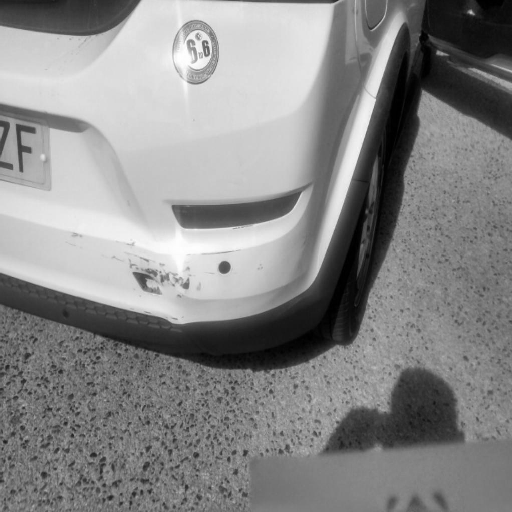

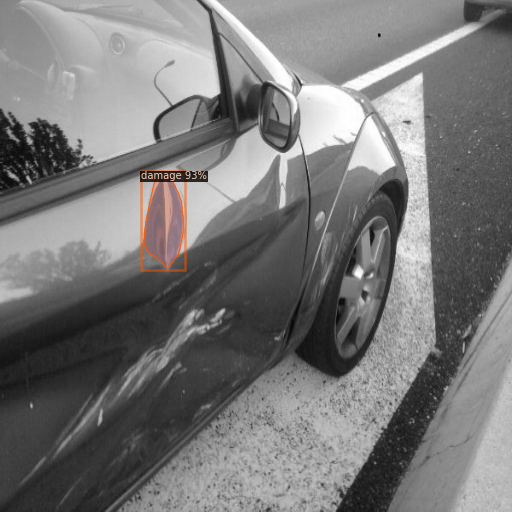

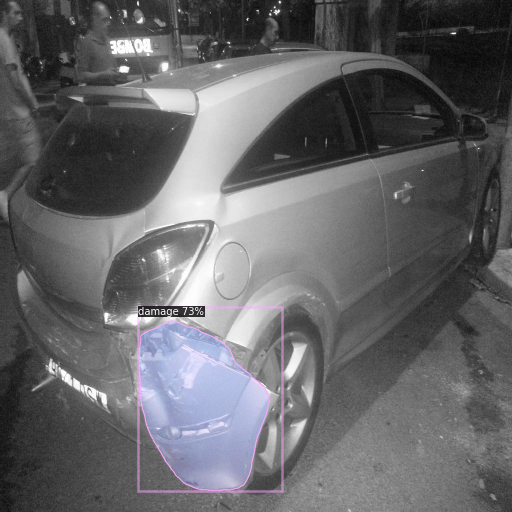

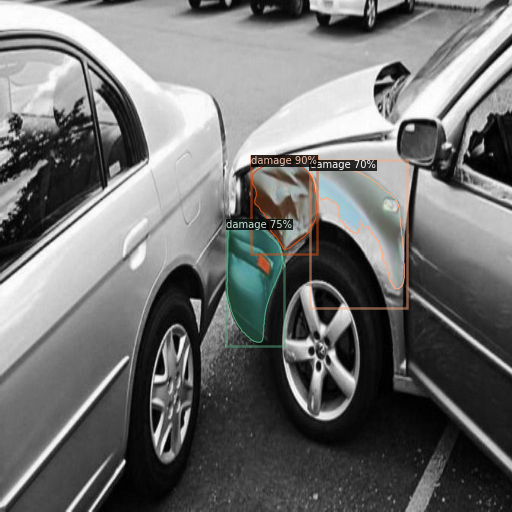

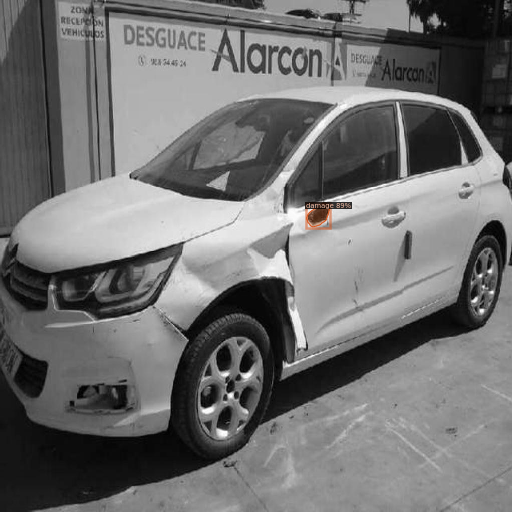

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts= DatasetCatalog.get('Validation data')
val_crash_metadata = MetadataCatalog.get('Validation data')

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_crash_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# Evaluate the model using different Average Precisions

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
evaluator = COCOEvaluator("Validation data", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "Validation data")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[01/10 17:34:47 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./val/COCO_val_annos.json
[01/10 17:34:47 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   damage   | 24           |
|            |              |
[01/10 17:34:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/10 17:34:47 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[01/10 17:34:47 d2.data.common]: Serialized dataset takes 0.01 MiB
[01/10 17:34:47 d2.evaluation.evaluator]: Start inference on 11 batches
[01/10 17:34:50 d2.evaluation.evaluator]: Inference done 11/11. Dataloading: 0.0015 s/iter. Inference: 0.2825 s/iter. Eval: 0.0059 s/iter. Total: 0.2899 s/iter. ETA=0:00:00
[01/10 17:34:50 d2.evaluation.evaluator]: Total inference time: 0:00:01.801096 (0.300183 s / iter pe

## The trained model achieves a decent AP on the validation dataset, and it can detect the damage on different images, on some cases segmenting more area.
## The used model (Detectron2) is known to achieve good results, in order to improve the task more data would be needed, but with less than 200 images we can see that the model is performing well.
## The model was also trained without Data Augmentation and the results had a lower AP, but the setting of DataAgumentation is crucial to achieve good results.

# Some visualizations on the augmented data

In [ ]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

[01/10 17:34:50 d2.data.datasets.coco]: Loaded 59 images in COCO format from ./train/COCO_train_annos.json
[01/10 17:34:50 d2.data.build]: Removed 0 images with no usable annotations. 59 images left.
[01/10 17:34:50 d2.data.build]: Using training sampler TrainingSampler
[01/10 17:34:50 d2.data.common]: Serializing 59 elements to byte tensors and concatenating them all ...
[01/10 17:34:50 d2.data.common]: Serialized dataset takes 0.03 MiB


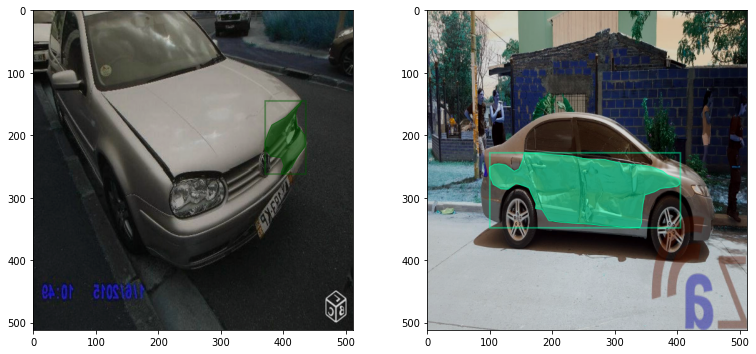

In [ ]:
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:int(rows*cols)]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=crash_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])